In [360]:
from IPython.display import HTML


# Exploration of the notMNIST Dataset 

In [362]:
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

In [7]:
import sklearn
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import seaborn as sns
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt
from sklearn.externals import joblib

%matplotlib inline

In [561]:
def plot_confusion_matrix(cm, classes,figname,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(figname)

In [8]:
# load data
with open('notMNIST.pickle', 'rb') as f: 
    data = pickle.load(f)

train_dataset = data['train_dataset']
train_labels = data['train_labels']

In [9]:
train_label_names = ['A','B','C','D','E','F','G','H','I','J']

In [10]:
m = len(train_dataset)
k = len(train_label_names)
print("{0} examples loaded".format(m))
print("{0} classes".format(k))

200000 examples loaded
10 classes


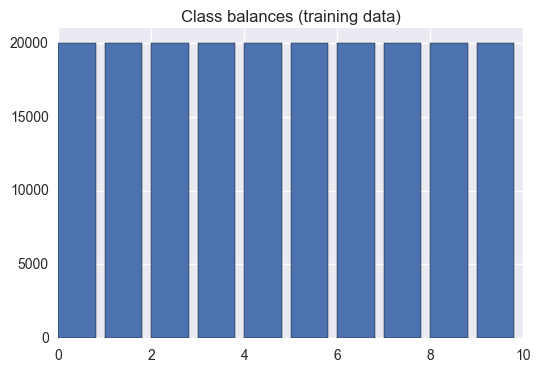

In [541]:
plt.bar(range(k),np.bincount(train_labels))
plt.ylim(0,21000)
plt.title("Class balances (training data)")
plt.savefig('class_balances_raw.png')

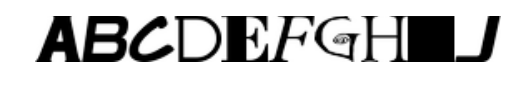

In [546]:
# def plot_images(data,randomize=True,):

images = []

for l in range(k):
    indices = np.where(train_labels == l)[0]
    chosen = random.choice(indices)
    images += [train_dataset[chosen]]

plt.imshow(np.hstack(images),cmap='Greys')
plt.axis('off')
# plt.savefig('data_sample.png')
plt.show()

Note that "I" appears to be a completely black image. Let's count how many of these occur in our training set for each label, then filter these 'blank' images out.

In [12]:
blank_counts = [0]*k
blank_indices = []
for i,x,y in zip(range(m),train_dataset,train_labels):
    if np.unique(x).size == 1:
        blank_counts[y] += 1
        blank_indices += [i]

print(blank_counts)    

[0, 8, 5, 2, 4, 4, 8, 7, 2134, 7]


Here we see that class 8 ("I") had the most 'blanks'.

In [13]:
train_dataset_cleaned = np.delete(train_dataset,blank_indices,axis=0)
train_labels_cleaned =  np.delete(train_labels,blank_indices,axis=0)
print(train_dataset_cleaned.shape)
print(train_labels_cleaned.shape)

(197821, 28, 28)
(197821,)


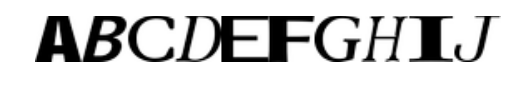

In [547]:
images = []

for l in range(k):
    indices = np.where(train_labels_cleaned == l)[0]
    chosen = random.choice(indices)
    images += [train_dataset_cleaned[chosen]]

plt.imshow(np.hstack(images),cmap='Greys')
plt.axis('off')
plt.savefig('data_sample_cleaned.png')
plt.show()

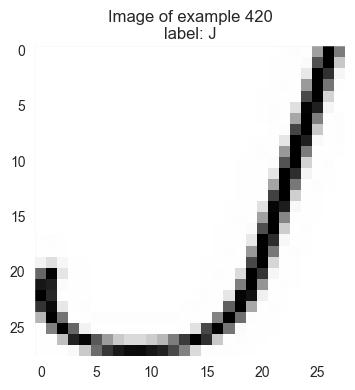

In [552]:
# zoom in on a particular example

example_index = 420
example_label = train_label_names[train_labels_cleaned[example_index]]
plt.imshow(train_dataset_cleaned[example_index],interpolation="none")
plt.title('Image of example {0}\nlabel: {1}'.format(example_index,example_label))
plt.grid(False)
plt.savefig('training_example.png')
plt.show()

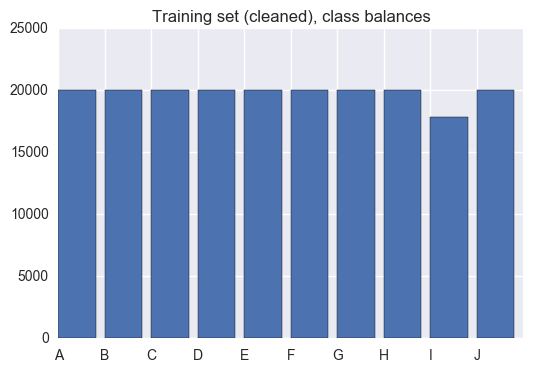

In [548]:
# check class balances
balances = np.bincount(train_labels_cleaned)
plt.bar(range(10),balances)
plt.title('Training set (cleaned), class balances')
plt.xticks(range(10),train_label_names)
plt.ylim(0,25000)
plt.savefig('training_set_class_balances.png')
plt.show()




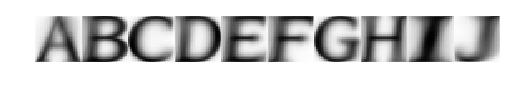

In [13]:
# plot averages of pixels per class label

averages = []

for label in range(k):
    k_indices = np.where(train_labels_cleaned == label)[0]
#     plt.imshow(np.mean(train_dataset_cleaned[k_indices],axis=0),interpolation='none')    
#     plt.
    averages += [np.mean(train_dataset_cleaned[k_indices],axis=0)]
plt.imshow(np.hstack(averages),interpolation='none')    
plt.axis('off')
plt.savefig("pixel_averages.png")
plt.show()



If we average the pixels out for each class, the letter's general shape is clear. Here are the medians:

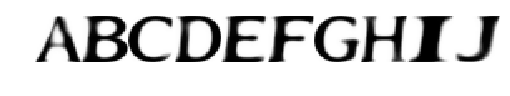

In [357]:
medians = []

for label in range(k):
    k_indices = np.where(train_labels_cleaned == label)[0]
#     plt.imshow(np.mean(train_dataset_cleaned[k_indices],axis=0),interpolation='none')    
#     plt.
    medians += [np.median(train_dataset_cleaned[k_indices],axis=0)]
plt.imshow(np.hstack(medians),interpolation='none')    
plt.axis('off')
plt.savefig("pixel_medians.png")
plt.show()


A limitation of using pixel averages/medians is that doesn't take into account that some letters are made of white pixels with a black background, or are only outlines of the letter.

In [380]:
# plot letters that have mostly whitespace vs darkspace

# 0.5 is darkest, -0.5 is lightest pixel

# test = np.zeros((28,28)) + -0.5
# test[0,0] = 0.5
# plt.imshow(test,interpolation='none')
# plt.grid('off')

## Dimensionality Reduction - PCA

How can we visualize the relationship between letters? We can try to reduce the dimensions of the data and plot the points. We try reducing it to three dimensions via PCA - first by flattening the image from 28x28 matrix to a 784-dimensional vector.

In [16]:
from sklearn.decomposition import PCA
y = train_labels_cleaned
X_flat = [x.flatten() for x in train_dataset_cleaned]

In [19]:
pca = PCA()
X_pca = pca.fit(X_flat).transform(X_flat)

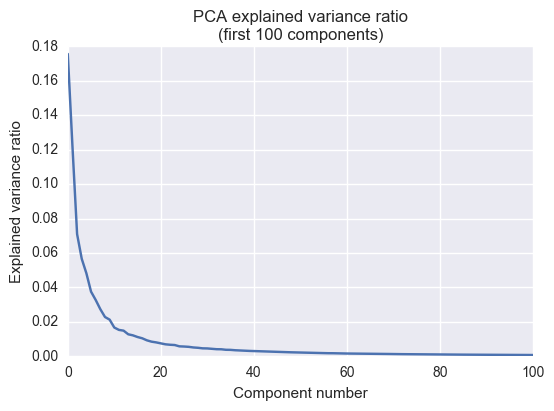

In [521]:
plt.plot(pca.explained_variance_ratio_)
plt.title('PCA explained variance ratio\n(first 100 components)')
plt.xlabel('Component number')
plt.ylabel('Explained variance ratio')
plt.xlim(0,100)
plt.savefig('pca_explained_variance.png')

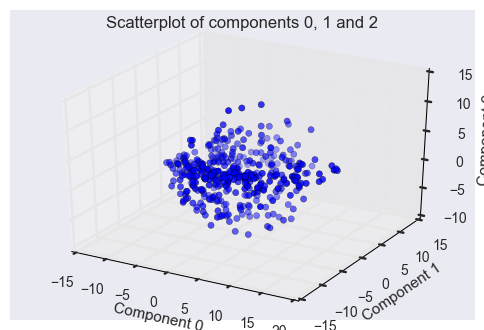

In [18]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
n = 100

ax.scatter(X_pca[::500,0],X_pca[::500,1], X_pca[::500,2], 
#            c=c, marker=m
#            c=train_labels_cleaned,cmap='Set1'
          )

ax.set_xlabel('Component 0')
ax.set_ylabel('Component 1')
ax.set_zlabel('Component 2')

plt.title('Scatterplot of components 0, 1 and 2')
plt.savefig('pca_3d_scatter.png')
# for angle in range(0, 360):
#     ax.view_init(30, angle)
#     plt.draw()
#     plt.pause(.001)
plt.show()

For a closer look, we plot pairs of axes and color the points by class. The plots contain a sample of the original data. The sample's classes are roughly balanced.


In [20]:
stride = 300

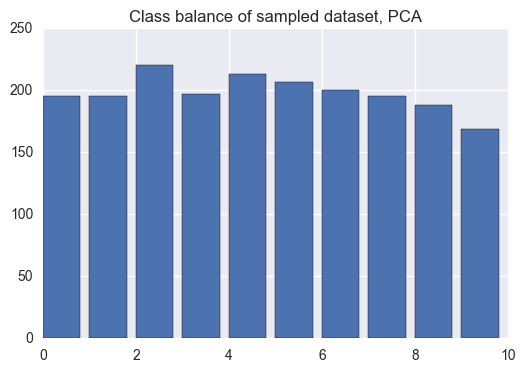

In [522]:
# class balance of sample
plt.bar(range(k),np.bincount(train_labels_cleaned[::stride]))
plt.title("Class balance of sampled dataset, PCA")
plt.savefig("pca_class_balance.png")

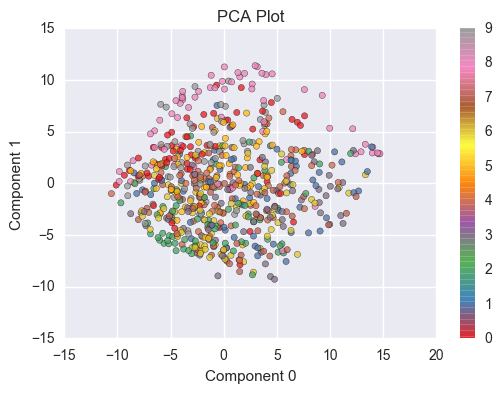

In [22]:
plt.scatter(X_pca[::stride,0],X_pca[::stride,1],
            c=train_labels_cleaned[::stride],cmap='Set1',alpha=0.75)
plt.xlabel('Component 0')
plt.ylabel('Component 1')
plt.colorbar()
plt.title('PCA Plot')
plt.savefig('pca_c0c1.png')
plt.show()

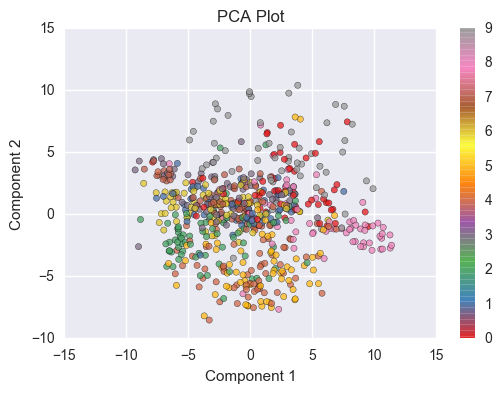

In [23]:
plt.scatter(X_pca[::stride,1],X_pca[::stride,2],
            c=train_labels_cleaned[::stride],cmap='Set1',alpha=0.75)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar()
plt.title('PCA Plot')
plt.savefig('pca_c1c2.png')
plt.show()

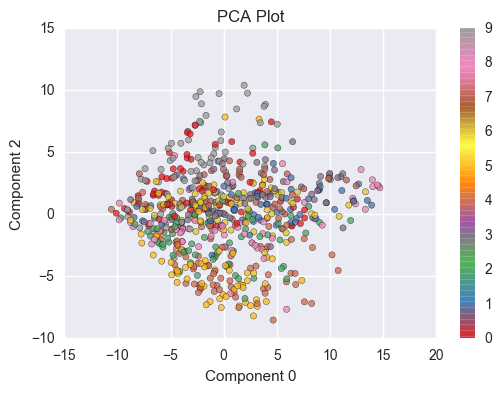

In [24]:
plt.scatter(X_pca[::stride,0],X_pca[::stride,2],
            c=train_labels_cleaned[::stride],cmap='Set1',alpha=0.75)
plt.xlabel('Component 0')
plt.ylabel('Component 2')
plt.colorbar()
plt.title('PCA Plot')
plt.savefig('pca_c0c2.png')
plt.show()

There is a bit of separation between classes 8 and 9 from other observations. However there isn't much other information that helps visually separate different classes. 

# Dimensionality Reduction - t-SNE

We use a more sophisticated dimensionality reduction technique: t-SNE. Due to memory limitations, we sample every 100th data point from our PCA transformed dataset, and feed the its first 50 principal components of our data into sklearn's t-SNE function.

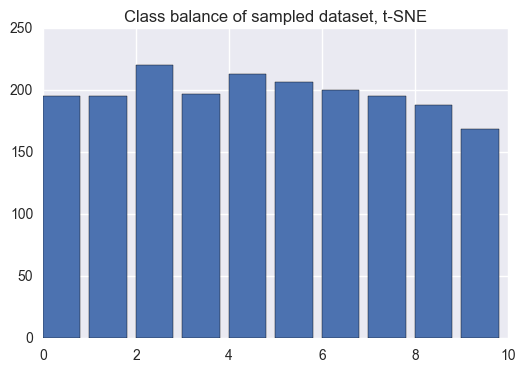

In [524]:
stride = 100 # take every 100th data point

# class balance of sample
plt.bar(range(k),np.bincount(train_labels_cleaned[::stride]))
plt.title("Class balance of sampled dataset, t-SNE")
plt.savefig("tsne_class_balance.png")

In [525]:
from sklearn.manifold import TSNE

stride = 100
perplexities = [10,20,30,40,50]
X_embedded_all = [] # keep a running list of all embeddings
for p in perplexities:
    X_embedded = TSNE(n_components=2,random_state=42,perplexity=p).fit_transform(X_pca[::stride,0:50])
    num_sampled = X_embedded.shape[0]
    plt.scatter(X_embedded[:,0],X_embedded[:,1],c=train_labels_cleaned[::stride],alpha=0.75,
            cmap='Set1')
    plt.colorbar()
    plt.title('t-SNE on {0} points\nperplexity: {1}'.format(num_sampled,p))
    plt.savefig('tsne_{0}pts_perplexity{1}.png'.format(num_sampled,p))
    plt.close()
    X_embedded_all += [X_embedded]

KeyboardInterrupt: 

Here, we change the perplexity value. In t-SNE, the perplexity parameter determines how it balances attention between local and global aspects of the dataset.

These visualizations provide clues to possible patterns in the data. Some interesting patterns emerge over at any perplexity value:

- Clusters with "G" (label) and "C" (label 2) are always adjacent to each other. The embedding could be capturing the similarity of the letters' shapes. Some particular groups of "I" examples are close to "J" examples. 
- We almost always see two distinct groups of "A" examples. Maybe one gruop could be lower case and the other upper case A's, which have different shapes.
- There is particular 'mixed' cluster of examples that contains all of the labels. Maybe some fonts maintain similar letters shapes/sizes from A-J?

Some additional questions to look into
- how many are usually in that cluster?
- which numbers appear there?
- which examples appear there?



Based on these we hypothesize that the representation that the embedding is capturing the varying shapes of each example. Let's take a look at the perplexity=30 plot:

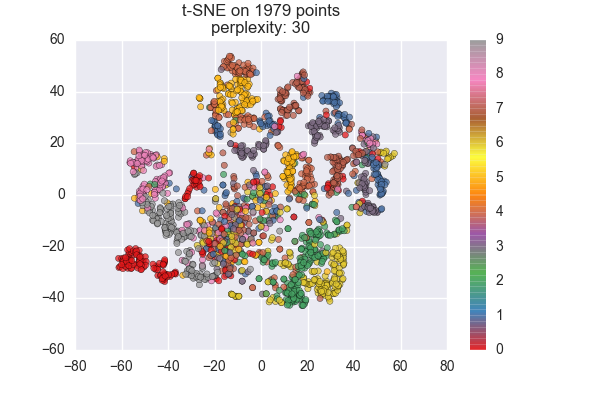

In [22]:
from IPython.display import Image
Image(filename='tsne_1979pts_perplexity30.png') 

In [ ]:
# data for plotting
p30_pts = X_embedded_all[2]
p30_labels = train_labels_cleaned[::stride]
p30_original = train_dataset_cleaned[::stride]

In [70]:
# given two pts return the points from data that lie within them 
def return_indices(x1,y1,x2,y2,data):
    indices = np.all((np.array([x1,y1]) <= data) & (data <= np.array([x2,y2])),axis=1)
    return indices

def plot_letters_adjacent(letters_list):
    acc = []
    for i in letters_list: acc += [i]
    plt.imshow(np.hstack(acc),interpolation='none')    
    plt.axis('off')
    plt.show()

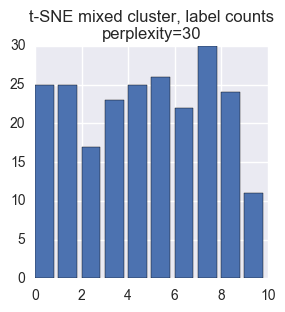

In [61]:
# Closer look at the 'mixed labels' cluster 
x1,y1,x2,y2 = -25,-25,0,0
mixed_labels_ind = return_indices(x1,y1,x2,y2,p30_pts)
mixed_labels = p30_original[mixed_labels_ind]
plt.figure(figsize=(3,3))
plt.bar(range(k),np.bincount(p30_labels[mixed_labels_ind]))
plt.title("t-SNE mixed cluster, label counts\nperplexity=30")
plt.show()
# return_indices(0,0,1,1,np.array([[0,-1],[1,1]]))
 



C and J show up the least in this mixed cluster, and H the most.

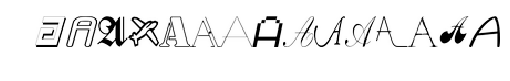

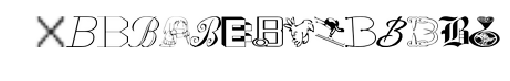

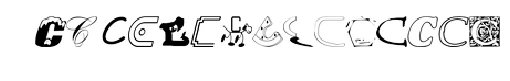

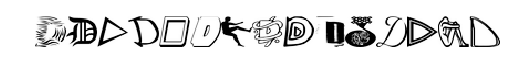

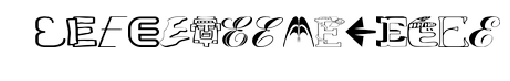

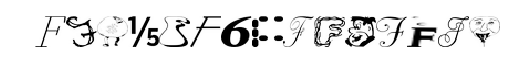

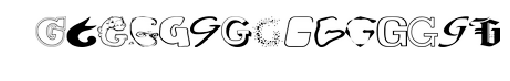

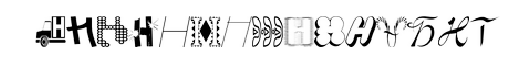

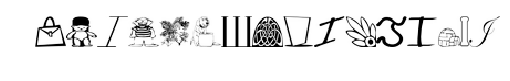

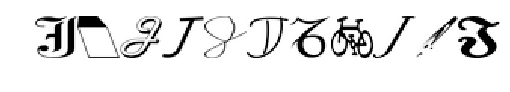

In [550]:
for l in range(k):
    ind = np.where(p30_labels[mixed_labels_ind] == l)[0][0:15]
    plot_letters_adjacent(mixed_labels[ind])

This cluster seems correspond mostly with thin letters or hollow ones - even to human, the letter is not as obvious or defined. Some aren't even letters!

In [130]:
# Closer look at the 2 clusters containing mostly A

x1,y1,x2,y2 = -60,-40,-40,-20
x3,y3,x4,y4 = -35,0,-20,10

a1_ind = return_indices(x1,y1,x2,y2,p30_pts)
a2_ind = return_indices(x3,y3,x4,y4,p30_pts)

print(np.bincount(p30_labels[a1_ind]))
print(np.bincount(p30_labels[a2_ind]))

[91]
[25  2  0  0  0  0  0  0  1]


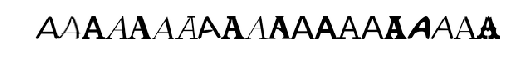

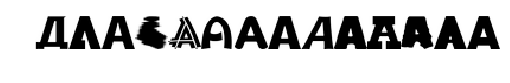

In [163]:
r = np.random.randint(0,25)
plot_letters_adjacent(p30_original[a1_ind][r:r+20])
plot_letters_adjacent(p30_original[a2_ind][r:r+20])

First cluster appears to capture thinner A's while the second is blockier ones.

Note that t-SNE does not preserve distances (as the bandwidth of the gaussian kernel varies with the density of the data) so we wouldn't be able to use this embedding to segment our data for classification.

## Model Training - Neural Network

Here we train a deep neural network (DNN) to classify the letter in the image, and visualize the last layer's activations to see how it abstracts features about the data. 

The t-SNE plots indicate there are indeed non-linear relationships between abstract features of the data and their the labels - something a neural network could capture better than a linear model. We can use the model for exploratory purposes, analyzing its predictions, prediction confidences, and layer activations which can to inform next steps of exploration and feature engineering. All models will share the same architecture - for visualization purposes we only use two neruons in the last layer (which would hurt model accuracy).

The first network will be our baseline, with an identity (linear) activation function. Here, the network will act as a linear model. We also try a network using a Rectified Linear Unit (ReLu) activation and one with a tanh activation function. The final activations for these will be a softmax function, which gives us a 10-dimensional probability vector, one probability per class. For each of these, the label with the highest probability reutrns the model's prediction. 

The best performance is from the tanh DNN.

In [172]:
X_nn = np.array(X_flat)

In [7]:
from sklearn.neural_network import MLPClassifier

In [ ]:
dnn_identity = MLPClassifier(
    hidden_layer_sizes=(50, 20, 2),
    activation='identity',
    solver='sgd',
    learning_rate = 'adaptive', 
    random_state=42,verbose=True,early_stopping=True

)

dnn_relu = MLPClassifier(
    hidden_layer_sizes=(50, 20, 2),
    activation='relu',
    solver='sgd',
    learning_rate = 'adaptive', 
#     learning_rate_init=.00005,
    random_state=42,verbose=True,early_stopping=True

)

dnn_tanh = MLPClassifier(
    hidden_layer_sizes=(50, 20, 2),
    activation='tanh',
#     solver='sgd',
#     learning_rate = 'adaptive', learning_rate_init=.00005,
    random_state=42,verbose=True,early_stopping=True

)


In [ ]:
# try a third neuron in hidden layer
dnn_tanh2 = MLPClassifier(
    hidden_layer_sizes=(50, 20, 3),
    activation='tanh',
#     solver='sgd',
#     learning_rate = 'adaptive', learning_rate_init=.00005,
    random_state=42,verbose=True,early_stopping=True

)
dnn_tanh2.fit(X_nn,y)
joblib.dump(dnn_tanh2, 'dnn_tanh_v2.pkl') 

In [ ]:
# try many neurons in hidden layer
dnn_tanh3 = MLPClassifier(
    hidden_layer_sizes=(50, 20, 20),
    activation='tanh',
#     solver='sgd',
    learning_rate = 'adaptive', learning_rate_init=.0005,
    random_state=42,verbose=True,early_stopping=True

)
dnn_tanh3.fit(X_nn,y)
joblib.dump(dnn_tanh3, 'dnn_tanh_v3.pkl') 

In [ ]:
dnn_identity.fit(X_nn,y)

joblib.dump(dnn_identity, 'dnn_identity.pkl') 

In [ ]:
dnn_relu.fit(X_nn,y)
joblib.dump(dnn_relu, 'dnn_relu.pkl') 

In [ ]:
dnn_tanh.fit(X_nn,y)
joblib.dump(dnn_tanh, 'dnn_tanh.pkl') 

In [177]:
dnn_identity = joblib.load('dnn_identity.pkl') 
dnn_relu = joblib.load('dnn_relu.pkl') 
dnn_tanh = joblib.load('dnn_tanh.pkl') 
dnn_tanh2 = joblib.load('dnn_tanh_v2.pkl') 

We can run a sample of our observations through the network and plot what their values are at each layer. We chose the final hidden layer to have 2 neurons so we can can visualize its activations with a scatterplot.

In [285]:
# Returns the activation values of any intermediate layer of the neural network 
def propagate(input_layer, layer_nr, dnn, activation_function):
    
    layer = input_layer
    for intercepts, weights in zip(dnn.intercepts_[:layer_nr], dnn.coefs_[:layer_nr]):
        layer = activation_function(layer.dot(weights) + intercepts)
    return layer
# Obtain the activation values of any intermediate layer of the 
# neural network, starting from any previous layer
def propagate2(input_layer, layer_nr, dnn, activation_function,layer_start=0):    
    layer = input_layer
    for intercepts, weights in zip(dnn.intercepts_[layer_start:layer_nr], 
                                   dnn.coefs_[layer_start:layer_nr]):
        layer = activation_function(layer.dot(weights) + intercepts)
    return layer
# Computes softmax values for a score matrix X
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x)/np.sum(np.exp(x),axis=0)

In [ ]:
hl_identity = propagate(X_nn, 3, dnn_identity, lambda x: x)
hl_relu = propagate(X_nn, 3, dnn_relu, lambda x: np.maximum(0,x))
hl_tanh = propagate(X_nn, 3, dnn_tanh, np.tanh)
hl_tanh2 = propagate(X_nn, 3, dnn_tanh2, np.tanh)

In [381]:
# sns.boxplot(predicted_probs.max(axis=1))
# plt.title('Distribution of Prediction Confidences,\ntanh DNN')

The final activations are not able to clearly separate the data, as the network is simply linear.

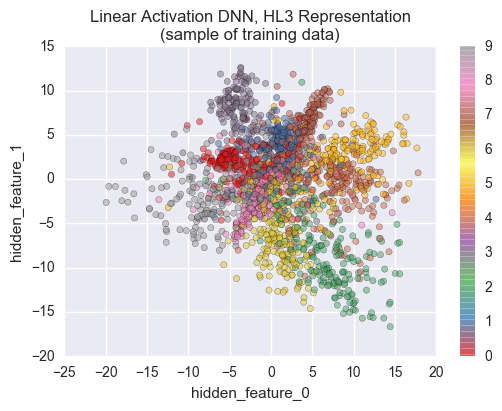

In [553]:
# plot a sample
stride = 100
plt.scatter(hl_identity[::stride,0],hl_identity[::stride,1],c=y[::stride],cmap='Set1',alpha=0.5)
plt.colorbar()
plt.title('Linear Activation DNN, HL3 Representation\n(sample of training data)')
plt.xlabel("hidden_feature_0")
plt.ylabel("hidden_feature_1")
plt.savefig('dnn_identity_hl3.png')
plt.show()

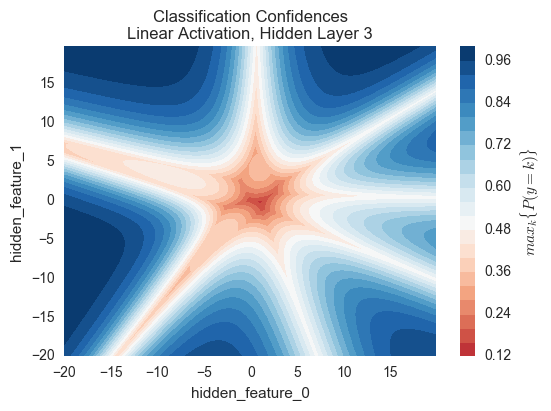

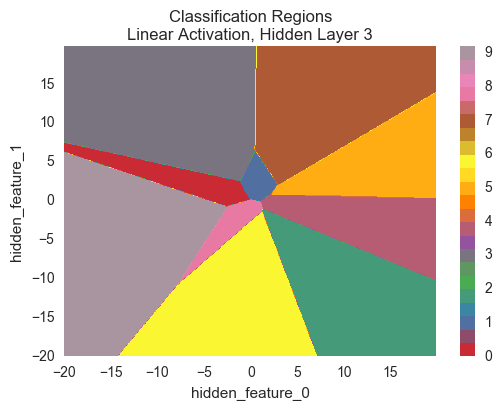

In [554]:
# for linear network, plot classification regions + probability contour
xx, yy = np.mgrid[-20:20:.1, -20:20:.1]
grid = np.c_[xx.ravel(), yy.ravel()]

identity_grid_probs = softmax(propagate2(grid,4,dnn_identity,lambda x:x,layer_start=3).T).T
identity_prob_contour = identity_grid_probs.max(axis=1).reshape(xx.shape)
identity_classification_regions = identity_grid_probs.argmax(axis=1).reshape(xx.shape)

f, ax = plt.subplots()
contour = ax.contourf(xx, yy, identity_prob_contour, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)

ax_c.set_label("$max_k\{P(y = k)\}$")
# ax_c.set_ticks([0, .25, .5, .75, 1])
ax.set_xlabel('hidden_feature_0')
ax.set_ylabel('hidden_feature_1')
ax.set_title('Classification Confidences\nLinear Activation, Hidden Layer 3')
plt.savefig('dnn_identity_probcontour.png')
plt.show()

f, ax = plt.subplots()

contour = ax.contourf(xx, yy, identity_classification_regions, 25, cmap="Set1")
ax_c = f.colorbar(contour)
ax.set_xlabel('hidden_feature_0')
ax.set_ylabel('hidden_feature_1')
ax.set_title('Classification Regions\nLinear Activation, Hidden Layer 3')
# ax_c.set_label(")
ax_c.set_ticks(range(k))
plt.savefig('dnn_identity_classregions.png')
plt.show()
# plt.imshow(reshaped_layer1[:,:,45],interpolation="none")
# plt.grid('off')

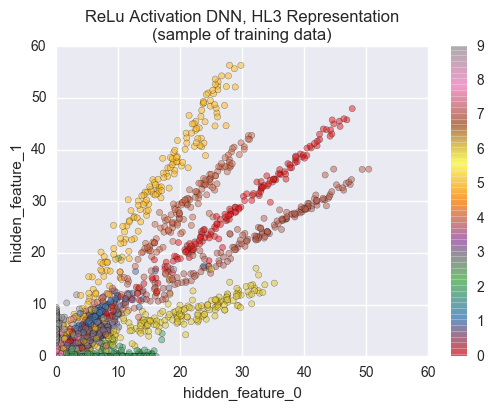

In [555]:
# plot a sample
stride = 100
plt.scatter(hl_relu[::stride,0],hl_relu[::stride,1],c=y[::stride],cmap='Set1',alpha=0.5)
plt.colorbar()
plt.title('ReLu Activation DNN, HL3 Representation\n(sample of training data)')
plt.xlabel("hidden_feature_0")
plt.ylabel("hidden_feature_1")
plt.savefig('dnn_relu_hl3.png')

plt.xlim(0,)
plt.ylim(0,)
plt.show()

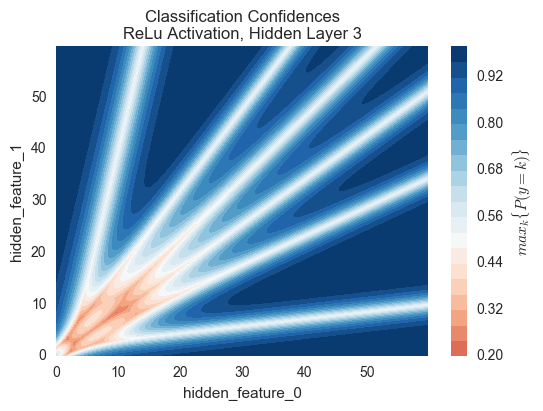

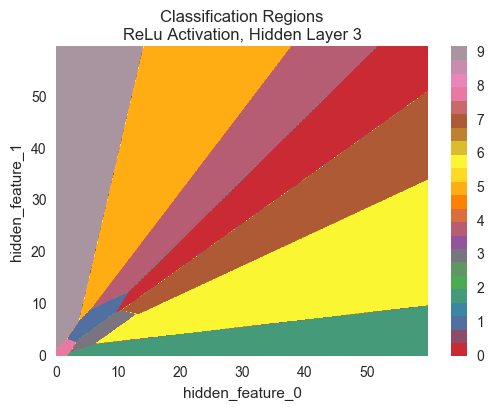

In [556]:
# for relu network, plot classification regions + probability contour
xx, yy = np.mgrid[0:60:.1, 0:60:.1]
grid = np.c_[xx.ravel(), yy.ravel()]

relu_grid_probs = softmax(propagate2(grid,4,dnn_relu,lambda x:x,layer_start=3).T).T
relu_prob_contour = relu_grid_probs.max(axis=1).reshape(xx.shape)
relu_classification_regions = relu_grid_probs.argmax(axis=1).reshape(xx.shape)

f, ax = plt.subplots()
contour = ax.contourf(xx, yy, relu_prob_contour, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)

ax_c.set_label("$max_k\{P(y = k)\}$")
# ax_c.set_ticks([0, .25, .5, .75, 1])
ax.set_xlabel('hidden_feature_0')
ax.set_ylabel('hidden_feature_1')
ax.set_title('Classification Confidences\nReLu Activation, Hidden Layer 3')
plt.savefig('dnn_relu_probcontour.png')
plt.show()

f, ax = plt.subplots()

contour = ax.contourf(xx, yy, relu_classification_regions, 25, cmap="Set1")
ax_c = f.colorbar(contour)
ax.set_xlabel('hidden_feature_0')
ax.set_ylabel('hidden_feature_1')
ax.set_title('Classification Regions\nReLu Activation, Hidden Layer 3')
# ax_c.set_label(")
ax_c.set_ticks(range(k))
plt.savefig('dnn_relu_classregions.png')

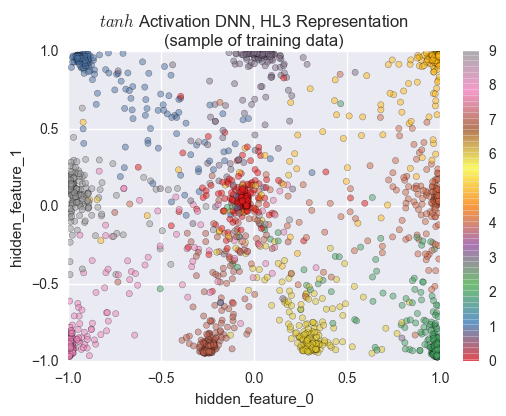

In [557]:
# plot a sample
stride = 100
plt.scatter(hl_tanh[::stride,0],hl_tanh[::stride,1],c=train_labels_cleaned[::stride],cmap='Set1',alpha=0.5)
plt.colorbar()
plt.title('$tanh$ Activation DNN, HL3 Representation\n(sample of training data)')
plt.xlabel("hidden_feature_0")
plt.ylabel("hidden_feature_1")
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.savefig('dnn_tanh_hl3.png')
plt.show()

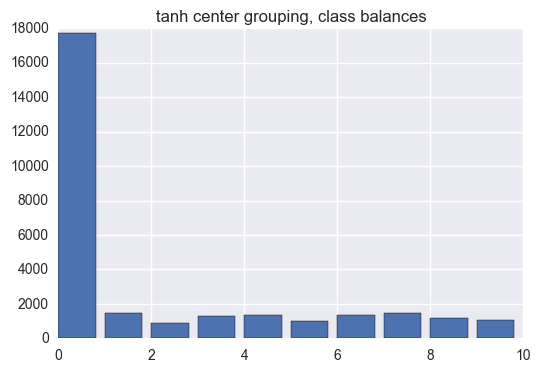

In [531]:
# how many of each class are there in the centre gruoping?
plt.bar(range(k),np.bincount(train_labels_cleaned[return_indices(-0.25,-0.25,0.25,0.25,hl_tanh)]))
plt.title('tanh center grouping, class balances')
plt.savefig('tanh_hl3_center_grouping.png')

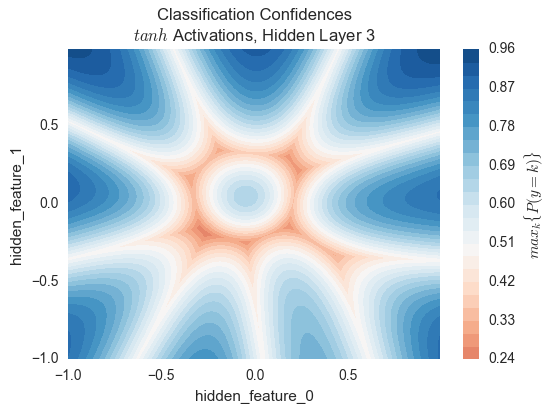

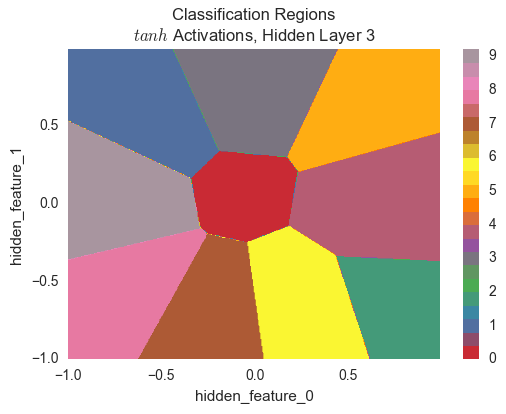

In [558]:
# for tanh network, plot classification regions + probability contour
xx, yy = np.mgrid[-1:1:.005, -1:1:.005]
grid = np.c_[xx.ravel(), yy.ravel()]

tanh_grid_probs = softmax(propagate2(grid,4,dnn_tanh,lambda x:x,layer_start=3).T).T
tanh_prob_contour = tanh_grid_probs.max(axis=1).reshape(xx.shape)
tanh_classification_regions = tanh_grid_probs.argmax(axis=1).reshape(xx.shape)

f, ax = plt.subplots()
contour = ax.contourf(xx, yy, tanh_prob_contour, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)

ax_c.set_label("$max_k\{P(y = k)\}$")
# ax_c.set_ticks([0, .25, .5, .75, 1])
ax.set_xlabel('hidden_feature_0')
ax.set_ylabel('hidden_feature_1')
ax.set_title('Classification Confidences\n$tanh$ Activations, Hidden Layer 3')
plt.savefig('dnn_tanh_probcontour.png')

plt.show()

f, ax = plt.subplots()
contour = ax.contourf(xx, yy, tanh_classification_regions, 25, cmap="Set1")

ax_c = f.colorbar(contour)
ax.set_xlabel('hidden_feature_0')
ax.set_ylabel('hidden_feature_1')
ax.set_title('Classification Regions\n$tanh$ Activations, Hidden Layer 3')
plt.savefig('dnn_tanh_classregions.png')
# ax_c.set_label(")
ax_c.set_ticks(range(k))

In [405]:
# load in validation data

cv_dataset = data['valid_dataset']
cv_labels = data['valid_labels']
y_cv = cv_labels
X_flat_cv = np.array([x.flatten() for x in cv_dataset])

In [437]:
cv_dataset.shape

(10000, 28, 28)

Normalized confusion matrix
[[ 0.888  0.016  0.     0.025  0.011  0.003  0.019  0.022  0.003  0.013]
 [ 0.094  0.787  0.003  0.033  0.015  0.005  0.013  0.012  0.01   0.028]
 [ 0.039  0.002  0.857  0.004  0.032  0.002  0.042  0.014  0.006  0.002]
 [ 0.079  0.034  0.003  0.845  0.004  0.014  0.003  0.006  0.004  0.008]
 [ 0.062  0.006  0.036  0.007  0.818  0.021  0.032  0.01   0.003  0.005]
 [ 0.053  0.004  0.003  0.016  0.048  0.849  0.009  0.007  0.003  0.008]
 [ 0.08   0.006  0.033  0.004  0.017  0.008  0.815  0.029  0.006  0.002]
 [ 0.078  0.007  0.001  0.005  0.004  0.005  0.037  0.832  0.025  0.006]
 [ 0.059  0.007  0.003  0.008  0.017  0.003  0.016  0.04   0.793  0.054]
 [ 0.069  0.02   0.     0.008  0.01   0.004  0.009  0.019  0.05   0.811]]


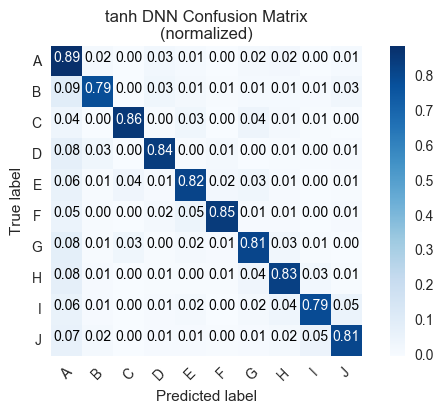

In [562]:
# confusion matrix of tanh dnn
from sklearn.metrics import confusion_matrix
import itertools
y_pred = dnn_tanh.predict(X_flat_cv)
cm = confusion_matrix(y_cv,y_pred)
plot_confusion_matrix(cm,train_label_names,normalize=True,title='tanh DNN Confusion Matrix\n(normalized)',figname='dnn_tanh_cm_normalized.png')
plt.grid('off')
plt.show()

trth:  [3 2 4 9 8 8 8 8 3 2]
pred:  [9 8 5 3 9 9 9 4 1 4]


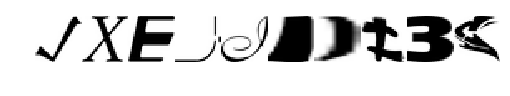

trth:  [9 9 5 7 1 9 4 5 5 8]
pred:  [8 8 4 5 3 8 2 3 3 9]


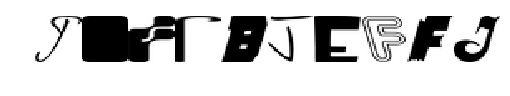

trth:  [1 1 8 0 3 6 0 6 5 9]
pred:  [4 9 5 5 5 1 3 2 8 1]


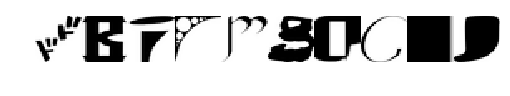

trth:  [7 9 5 2 8 1 7 6 6 3]
pred:  [3 4 3 4 9 5 4 2 5 5]


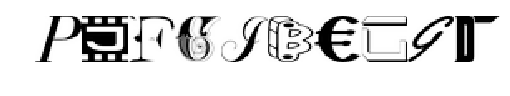

trth:  [1 3 5 1 2 8 9 1 3 5]
pred:  [3 1 4 3 5 9 5 3 5 4]


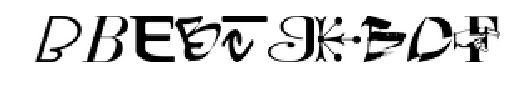

trth:  [9 0 5 6 6 6 0 8 4 6]
pred:  [8 5 4 2 2 5 3 9 2 4]


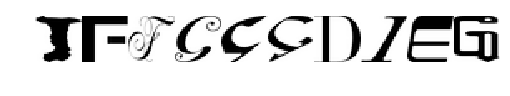

trth:  [4 5 4 2 5 8 8 5 1]
pred:  [5 3 2 4 4 4 9 4 5]


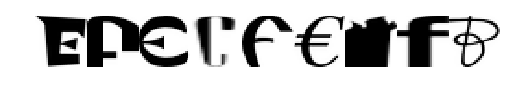

In [471]:
# when is the classifier confident but wrong?

wrong_high_prob_indices = np.where(np.logical_and((y_pred != y_cv),(y_pred_prob > 0.80)))
y_cv_wrong = y_cv[wrong_high_prob_indices]
y_pred_wrong = y_pred[wrong_high_prob_indices]
for n in range(0,69,10):
    print("trth: ",y_cv_wrong[n:n+10])
    print("pred: ",y_pred_wrong[n:n+10])
    plot_letters_adjacent(cv_dataset[wrong_high_prob_indices][n:n+10])


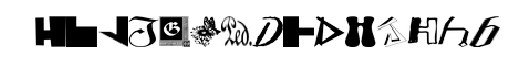

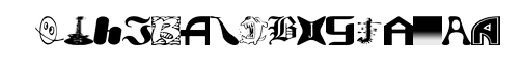

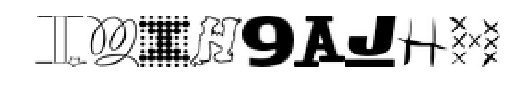

In [429]:
# least confident predictions of tanh
y_pred_prob = dnn_tanh.predict_proba(X_flat_cv).max(axis=1)
unconfident_indices = np.where(y_pred_prob < 0.30)

y_cv_wrong = y_cv[wrong_high_prob_indices]
y_pred_wrong = y_pred[wrong_high_prob_indices]
plot_letters_adjacent(cv_dataset[unconfident_indices][0:15])
plot_letters_adjacent(cv_dataset[unconfident_indices][15:31])
plot_letters_adjacent(cv_dataset[unconfident_indices][31:])




The most confusing letters to the classifier appear to be when the letters closely resemble images or are written in a non-conventional way. Or if they're not even letters.

It is likely that a human would also have difficulty determining which letters these images represent. For future character recognition tasks, the dataset should be futher vetted and cleaned to remove non-alphabetic images and symbols.

# Non-targeted Adversarial Input

Given the probability contour at the last hidden layer, we can generate inputs that the network misclassifies with high confidence and create an example. To do this, we can select a point on hidden layer's probability contour and invert the propagation to obtain an input that would have generated it.

In [479]:
def invert_propagation(hidden_layer, layer_nr, dnn):
    layer = hidden_layer
    for intercepts, weights in zip(dnn.intercepts_[layer_nr::-1], dnn.coefs_[layer_nr::-1]):
        inv_weight = np.linalg.pinv(weights)
        layer = (layer - intercepts).dot(inv_weight)
    return layer

In [563]:
def generate_adv(hidden_vector, dnn, ax,figname):
    input_vector = invert_propagation(hidden_vector, 2, dnn_identity)
    ax.imshow(input_vector.reshape((28, 28)), cmap='gray',interpolation='none')

    prediction = dnn.predict(input_vector.reshape(1, -1))[0]
    probability = np.max(dnn.predict_proba(input_vector.reshape(1, -1)))

    ax.set_title("Prediction: {:.0f}\n"
                 "Probability: {:.3f}"
#                  "Hidden vector: {}"
                 .format(prediction, probability, hidden_vector))
    ax.grid('off')
    plt.savefig(figname)
    

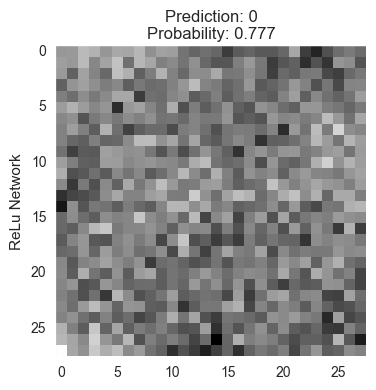

In [564]:
f, ax = plt.subplots()
generate_adv(np.array([5,50]),dnn_relu,ax,'dnn_relu_adversarial_input.png')
ax.set_ylabel("ReLu Network")


# Future Work

An interactive visualization can be built on top of the t-SNE scatterplot to easily click and explore what common properties each cluster of data has. This could offer insights into which features could be engineered to improve the network.

Convolutional neural networks have been used with much success in image processing tasks - using CNNs instead of a regular neural network would yield a higher accuracy.

### Bonus: visualization of last layer, 3 neurons

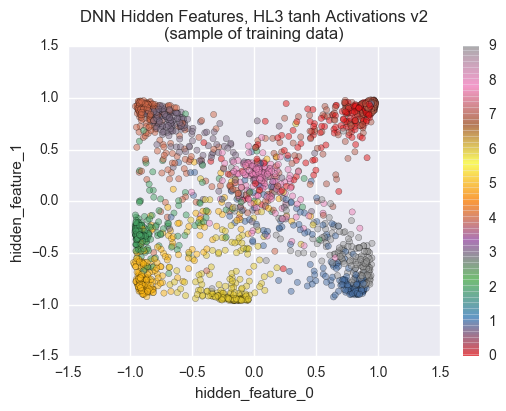

In [80]:
# plotting pairs of axes
plt.scatter(hl_tanh2[::stride,0],hl_tanh2[::stride,1],c=train_labels_cleaned[::stride],cmap='Set1',alpha=0.5)
plt.colorbar()
plt.title('DNN Hidden Features, HL3 tanh Activations v2\n(sample of training data)')
plt.xlabel("hidden_feature_0")
plt.ylabel("hidden_feature_1")
plt.show()


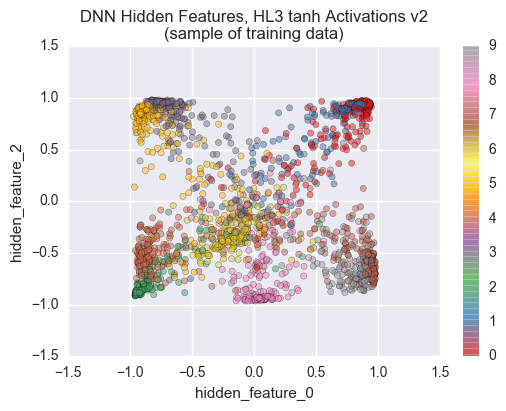

In [81]:
plt.scatter(hl_tanh2[::stride,0],hl_tanh2[::stride,2],c=train_labels_cleaned[::stride],cmap='Set1',alpha=0.5)
plt.colorbar()
plt.title('DNN Hidden Features, HL3 tanh Activations v2\n(sample of training data)')
plt.xlabel("hidden_feature_0")
plt.ylabel("hidden_feature_2")
plt.show()

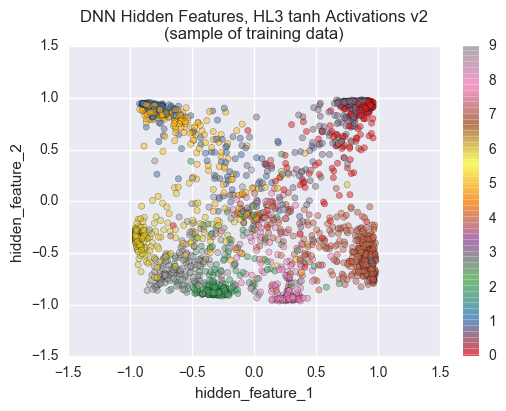

In [82]:
plt.scatter(hl_tanh2[::stride,1],hl_tanh2[::stride,2],c=train_labels_cleaned[::stride],cmap='Set1',alpha=0.5)
plt.colorbar()
plt.title('DNN Hidden Features, HL3 tanh Activations v2\n(sample of training data)')
plt.xlabel("hidden_feature_1")
plt.ylabel("hidden_feature_2")
plt.show()